In [1]:
%pip install alpha-vantage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.8/365.8 kB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 731.3 kB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.layers import Dropout
import xgboost
import pickle

# GET DATA FROM API

In [6]:
API_KEY = 'N5E4Q2IN4MMPFWGY'

In [7]:
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key=API_KEY, output_format='pandas')
data = ts.get_intraday(symbol='MSFT',interval='15min', outputsize='full')
data = data[0]
data.rename(lambda x: x[2:].strip(), axis='columns', inplace=True)
data

,open,high,low,close,volume
date,,,,,
2023-08-10 19:45:00,323.34,323.50,323.16,323.50,7120.0
2023-08-10 19:30:00,323.24,323.50,323.14,323.31,3840.0
2023-08-10 19:15:00,323.29,323.30,323.13,323.24,2741.0
2023-08-10 19:00:00,323.25,323.29,323.13,323.29,926.0
2023-08-10 18:45:00,323.26,323.37,323.11,323.29,1696.0
...,...,...,...,...,...
2023-07-13 05:00:00,339.21,339.35,339.15,339.21,1075.0
2023-07-13 04:45:00,339.15,339.21,339.04,339.16,1169.0
2023-07-13 04:30:00,339.17,339.23,339.00,339.00,2576.0


## Technical indicator for analyze data

In [8]:

from alpha_vantage.techindicators import TechIndicators
ti = TechIndicators(key=API_KEY, output_format='pandas')

### Rate of Change (ROC)

In [9]:
indicator_roc = ti.get_roc(symbol='MSFT', interval='15min', time_period=20)
indicator_roc = indicator_roc[0]
indicator_roc

,ROC
date,
2023-07-13 09:00:00,-0.0089
2023-07-13 09:15:00,0.1061
2023-07-13 09:30:00,0.6460
2023-07-13 09:45:00,0.4564
2023-07-13 10:00:00,0.3411
...,...
2023-08-10 18:45:00,0.5568
2023-08-10 19:00:00,-0.0269
2023-08-10 19:15:00,0.1208


### Simple Moving Average (SMA)

In [10]:
indicator_sma = ti.get_sma(symbol='MSFT', interval='15min', time_period=20)
indicator_sma = indicator_sma[0]
indicator_sma

,SMA
date,
2023-07-13 08:45:00,339.4747
2023-07-13 09:00:00,339.4732
2023-07-13 09:15:00,339.4912
2023-07-13 09:30:00,339.6007
2023-07-13 09:45:00,339.6781
...,...
2023-08-10 18:45:00,323.1399
2023-08-10 19:00:00,323.1355
2023-08-10 19:15:00,323.1550


### Relative Strength Index (RSI)

In [11]:
indicator_rsi = ti.get_rsi(symbol='MSFT', interval='15min', time_period=20)
indicator_rsi = indicator_rsi[0]
indicator_rsi

,RSI
date,
2023-07-13 09:00:00,49.7148
2023-07-13 09:15:00,55.4240
2023-07-13 09:30:00,65.9235
2023-07-13 09:45:00,61.4712
2023-07-13 10:00:00,58.5276
...,...
2023-08-10 18:45:00,48.4106
2023-08-10 19:00:00,48.4106
2023-08-10 19:15:00,47.9962


### Bolling Bands (BBANDS)

In [12]:
def BollingerBand(data, n_loockback, n_std=2):
    hlc_avg = (data.high + data.low + data.close)/3
    data_std = hlc_avg.rolling(window=n_loockback).std()
    data_upper = data.SMA + n_std * data_std
    data_lower = data.SMA - n_std * data_std
    return data.SMA, data_lower, data_upper

#### Merge indicators to data

In [14]:
original_df = pd.merge(data, indicator_roc, on='date', how='inner')
original_df = pd.merge(original_df, indicator_sma, on='date', how='inner')
original_df = pd.merge(original_df, indicator_rsi, on='date', how='inner')
# original_df = pd.merge(original_df, indicator_bb, on='date', how='inner')
original_df["Real Middle Band"], original_df["Real Lower Band"], original_df["Real Upper Band"] = BollingerBand(original_df, 20, 2)
original_df = original_df.dropna()
original_df = original_df.iloc[::-1]
original_df.to_csv('./DATA/MSFT.csv')
original_df

,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Lower Band,Real Upper Band
date,,,,,,,,,,,
2023-07-13 09:00:00,339.170,339.490,338.70,338.900,30491.0,-0.0089,339.4732,49.7148,339.4732,338.146293,340.800107
2023-07-13 09:15:00,338.880,340.000,338.14,339.540,71186.0,0.1061,339.4912,55.4240,339.4912,338.444702,340.537698
2023-07-13 09:30:00,339.560,342.470,339.02,341.190,2865597.0,0.6460,339.6007,65.9235,339.6007,338.831751,340.369649
2023-07-13 09:45:00,341.250,341.700,340.52,340.708,950046.0,0.4564,339.6781,61.4712,339.6781,338.863059,340.493141
2023-07-13 10:00:00,340.740,341.170,339.73,340.367,890681.0,0.3411,339.7360,58.5276,339.7360,338.832413,340.639587
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-10 14:00:00,321.520,323.450,321.45,323.377,440121.0,-0.9899,324.1594,46.7484,324.1594,320.748657,327.570143
2023-08-10 14:15:00,323.360,323.600,322.85,322.850,502337.0,-0.8842,324.0154,44.4830,324.0154,320.598247,327.432553
2023-08-10 14:30:00,322.900,323.183,322.54,322.965,581185.0,-0.7300,323.8966,45.0941,323.8966,320.476663,327.316537


# MODEL TRAINING

## 1. LSTM

### a. Prepare Input

In [17]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[338.9  ],
       [339.54 ],
       [341.19 ],
       ...,
       [322.965],
       [323.785],
       [323.6  ]])

In [18]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.3931315 ],
       [0.4075915 ],
       [0.44487122],
       ...,
       [0.03309986],
       [0.05162675],
       [0.0474469 ]])

In [19]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1245
1245


In [20]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (996, 60, 1)
Size validate:  (125, 60, 1)
Size test:  (124, 60, 1)


### b. Train Model

In [21]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM.h5")

Epoch 1/20
32/32 [==============================] - 6s 70ms/step - loss: 0.0299 - val_loss: 0.0073
Epoch 2/20
32/32 [==============================] - 2s 70ms/step - loss: 0.0033 - val_loss: 7.3398e-04
Epoch 3/20
32/32 [==============================] - 2s 74ms/step - loss: 0.0024 - val_loss: 6.3764e-04
Epoch 4/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0021 - val_loss: 5.1605e-04
Epoch 5/20
32/32 [==============================] - 2s 51ms/step - loss: 0.0020 - val_loss: 5.1727e-04
Epoch 6/20
32/32 [==============================] - 2s 51ms/step - loss: 0.0019 - val_loss: 4.9174e-04
Epoch 7/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0018 - val_loss: 4.8007e-04
Epoch 8/20
32/32 [==============================] - 2s 50ms/step - loss: 0.0017 - val_loss: 3.7760e-04
Epoch 9/20
32/32 [==============================] - 2s 51ms/step - loss: 0.0019 - val_loss: 4.4841e-04
Epoch 10/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0

/Users/minhduc/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### c. Test Model

In [22]:
model_lstm = load_model('./MODEL/LSTM.h5')

In [23]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

4/4 [==============================] - 1s 21ms/step


In [24]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

/var/folders/45/_wfmynmn3sn53x5yqxzhbl8m0000gp/T/ipykernel_5245/2018918845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


,date,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Lower Band,Real Upper Band,predictions
1181,2023-08-08 16:15:00,326.050,326.300,326.050,326.190,14978.0,0.5115,324.6816,53.0540,324.6816,321.166801,328.196399,325.499634
1182,2023-08-08 16:30:00,326.100,335.200,325.400,325.990,7219.0,0.6888,324.7931,51.4936,324.7931,321.223839,328.362361,325.724823
1183,2023-08-08 16:45:00,325.990,326.050,325.910,325.990,5036.0,0.8289,324.9271,51.4936,324.9271,321.525530,328.328670,325.894867
1184,2023-08-08 17:00:00,325.930,326.050,325.630,325.850,88763.0,0.4841,325.0056,50.3450,325.0056,321.562454,328.448746,326.012238
1185,2023-08-08 17:15:00,325.830,325.980,306.976,325.830,2339.0,0.5679,325.0976,50.1768,325.0976,321.646581,328.548619,326.068085
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,2023-08-10 14:00:00,321.520,323.450,321.450,323.377,440121.0,-0.9899,324.1594,46.7484,324.1594,320.748657,327.570143,322.938904
1301,2023-08-10 14:15:00,323.360,323.600,322.850,322.850,502337.0,-0.8842,324.0154,44.4830,324.0154,320.598247,327.432553,322.866211
1302,2023-08-10 14:30:00,322.900,323.183,322.540,322.965,581185.0,-0.7300,323.8966,45.0941,323.8966,320.476663,327.316537,322.850342
1303,2023-08-10 14:45:00,322.945,324.000,322.760,323.785,369818.0,-1.0407,323.7264,49.2847,323.7264,320.298768,327.154032,322.882019


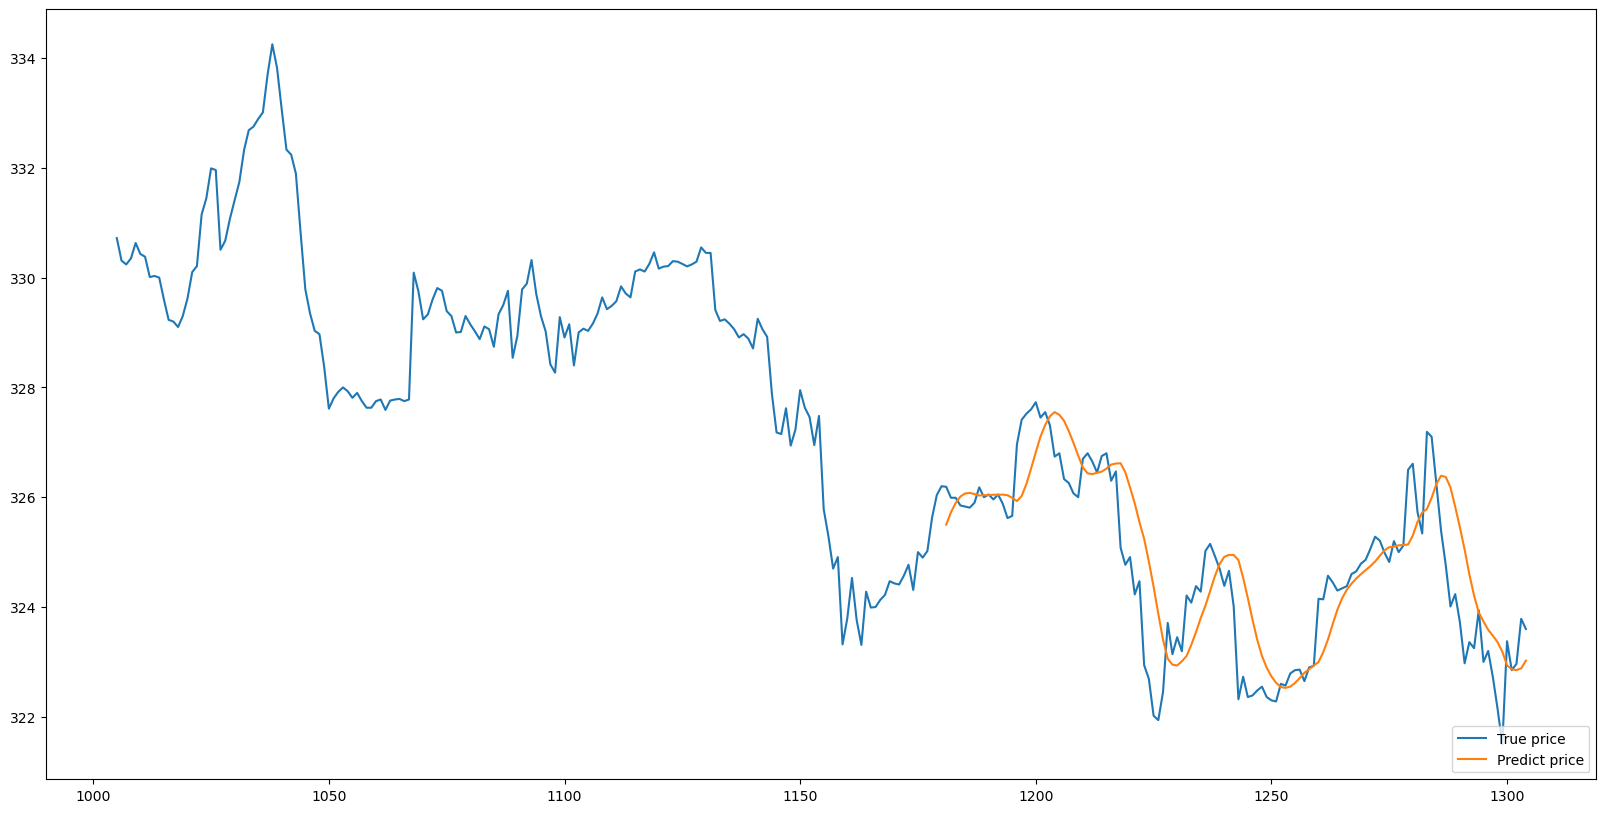

In [25]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [26]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset    

array([[ 3.38900e+02, -8.90000e-03],
       [ 3.39540e+02,  1.06100e-01],
       [ 3.41190e+02,  6.46000e-01],
       ...,
       [ 3.22965e+02, -7.30000e-01],
       [ 3.23785e+02, -1.04070e+00],
       [ 3.23600e+02, -1.07000e+00]])

In [27]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.3931315 , 0.39163321],
       [0.4075915 , 0.40237184],
       [0.44487122, 0.45278738],
       ...,
       [0.03309986, 0.32429732],
       [0.05162675, 0.29528434],
       [0.0474469 , 0.29254832]])

In [28]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1245
1245


In [29]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (996, 60, 2)
Size validate:  (125, 60, 2)
Size test:  (124, 60, 2)


In [30]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC.h5")

Epoch 1/20
32/32 [==============================] - 7s 93ms/step - loss: 0.0372 - val_loss: 0.0048
Epoch 2/20
32/32 [==============================] - 2s 66ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 3/20
32/32 [==============================] - 1s 43ms/step - loss: 0.0024 - val_loss: 8.3186e-04
Epoch 4/20
32/32 [==============================] - 1s 43ms/step - loss: 0.0022 - val_loss: 8.0477e-04
Epoch 5/20
32/32 [==============================] - 1s 42ms/step - loss: 0.0021 - val_loss: 5.5689e-04
Epoch 6/20
32/32 [==============================] - 1s 42ms/step - loss: 0.0021 - val_loss: 4.1918e-04
Epoch 7/20
32/32 [==============================] - 1s 42ms/step - loss: 0.0019 - val_loss: 4.0604e-04
Epoch 8/20
32/32 [==============================] - 1s 43ms/step - loss: 0.0018 - val_loss: 5.8394e-04
Epoch 9/20
32/32 [==============================] - 1s 45ms/step - loss: 0.0018 - val_loss: 7.7931e-04
Epoch 10/20
32/32 [==============================] - 2s 50ms/step - loss: 0.0017 

/Users/minhduc/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
model_lstm = load_model('./MODEL/LSTM_ROC.h5')

In [32]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]
predictions

4/4 [==============================] - 2s 18ms/step


array([326.1049 , 326.28906, 326.39597, 326.45795, 326.39493, 326.29523,
       326.18506, 326.09082, 326.05524, 326.02237, 326.01627, 326.0224 ,
       326.04507, 326.048  , 326.04248, 326.00162, 326.14102, 326.41245,
       326.70297, 326.9672 , 327.20782, 327.38007, 327.53122, 327.62173,
       327.60272, 327.5417 , 327.4026 , 327.22845, 327.0186 , 326.82483,
       326.75745, 326.78183, 326.8248 , 326.85632, 326.93192, 327.01727,
       326.94962, 326.8297 , 326.52396, 326.13937, 325.79053, 325.4443 ,
       325.17798, 324.81024, 324.44043, 324.0234 , 323.64505, 323.38998,
       323.38654, 323.43625, 323.5014 , 323.52908, 323.66876, 323.84   ,
       324.02408, 324.17535, 324.4115 , 324.6607 , 324.92773, 325.13358,
       325.21002, 325.26828, 325.18704, 324.8967 , 324.57617, 324.24353,
       323.92917, 323.62878, 323.31015, 323.04163, 322.81363, 322.65555,
       322.54706, 322.49875, 322.5128 , 322.5842 , 322.65012, 322.6891 ,
       322.76538, 322.87463, 323.15967, 323.48203, 

In [33]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

/var/folders/45/_wfmynmn3sn53x5yqxzhbl8m0000gp/T/ipykernel_5245/2018918845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


,date,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Lower Band,Real Upper Band,predictions
1181,2023-08-08 16:15:00,326.050,326.300,326.050,326.190,14978.0,0.5115,324.6816,53.0540,324.6816,321.166801,328.196399,326.104889
1182,2023-08-08 16:30:00,326.100,335.200,325.400,325.990,7219.0,0.6888,324.7931,51.4936,324.7931,321.223839,328.362361,326.289062
1183,2023-08-08 16:45:00,325.990,326.050,325.910,325.990,5036.0,0.8289,324.9271,51.4936,324.9271,321.525530,328.328670,326.395966
1184,2023-08-08 17:00:00,325.930,326.050,325.630,325.850,88763.0,0.4841,325.0056,50.3450,325.0056,321.562454,328.448746,326.457947
1185,2023-08-08 17:15:00,325.830,325.980,306.976,325.830,2339.0,0.5679,325.0976,50.1768,325.0976,321.646581,328.548619,326.394928
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,2023-08-10 14:00:00,321.520,323.450,321.450,323.377,440121.0,-0.9899,324.1594,46.7484,324.1594,320.748657,327.570143,323.157806
1301,2023-08-10 14:15:00,323.360,323.600,322.850,322.850,502337.0,-0.8842,324.0154,44.4830,324.0154,320.598247,327.432553,323.005493
1302,2023-08-10 14:30:00,322.900,323.183,322.540,322.965,581185.0,-0.7300,323.8966,45.0941,323.8966,320.476663,327.316537,322.968140
1303,2023-08-10 14:45:00,322.945,324.000,322.760,323.785,369818.0,-1.0407,323.7264,49.2847,323.7264,320.298768,327.154032,323.029785


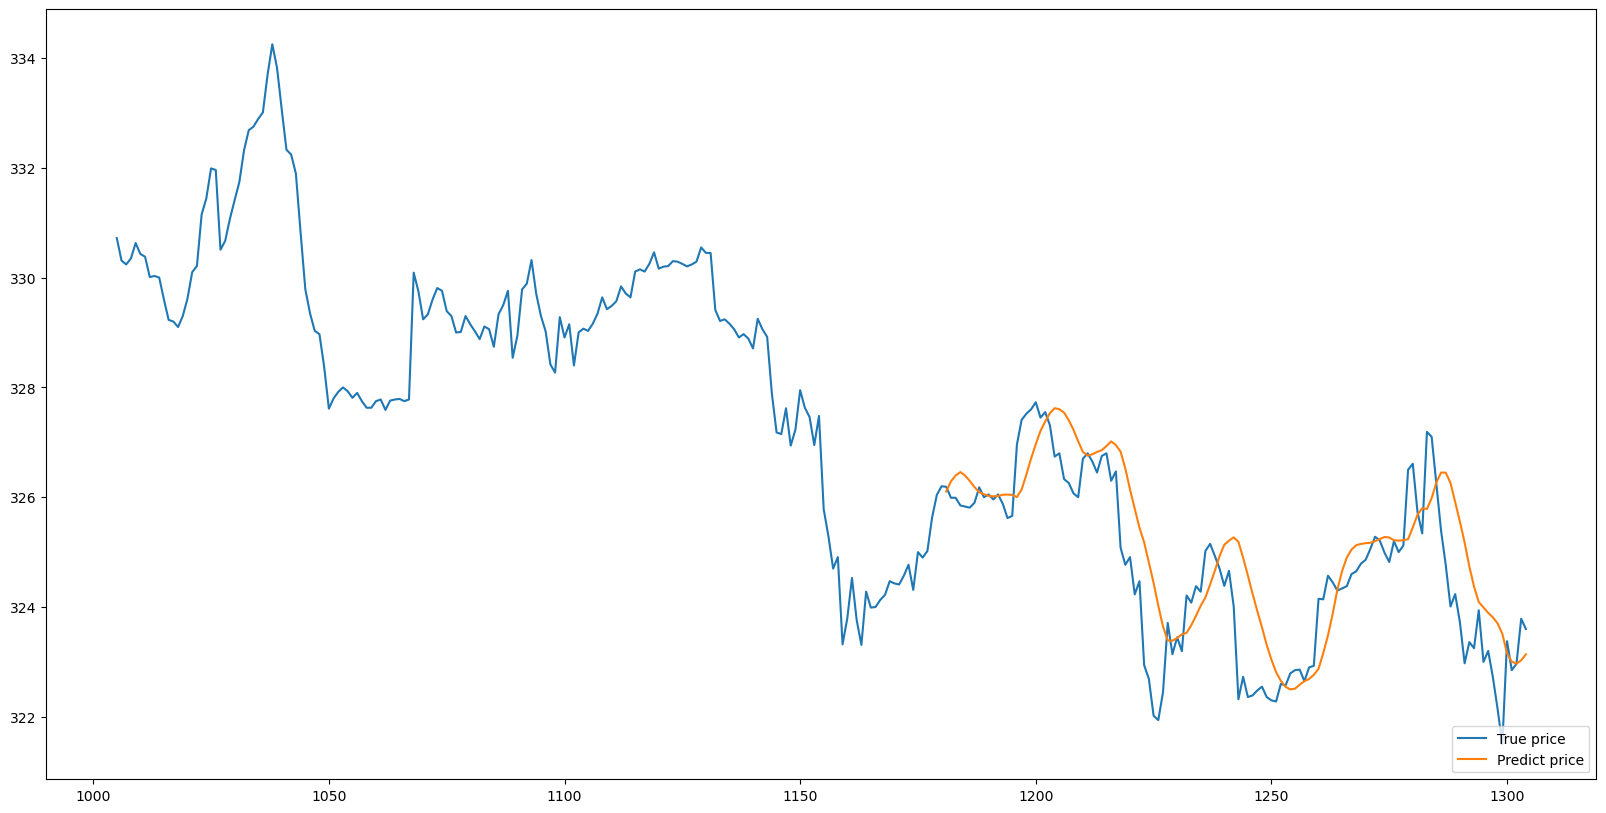

In [34]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

In [35]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_SMA.h5")


Epoch 1/20
32/32 [==============================] - 6s 65ms/step - loss: 0.0504 - val_loss: 0.0127
Epoch 2/20
32/32 [==============================] - 1s 41ms/step - loss: 0.0046 - val_loss: 0.0011
Epoch 3/20
32/32 [==============================] - 1s 41ms/step - loss: 0.0030 - val_loss: 6.8135e-04
Epoch 4/20
32/32 [==============================] - 1s 41ms/step - loss: 0.0029 - val_loss: 7.1941e-04
Epoch 5/20
32/32 [==============================] - 1s 41ms/step - loss: 0.0024 - val_loss: 9.7411e-04
Epoch 6/20
32/32 [==============================] - 1s 44ms/step - loss: 0.0025 - val_loss: 5.4450e-04
Epoch 7/20
32/32 [==============================] - 1s 43ms/step - loss: 0.0021 - val_loss: 6.5227e-04
Epoch 8/20
32/32 [==============================] - 1s 43ms/step - loss: 0.0019 - val_loss: 6.8918e-04
Epoch 9/20
32/32 [==============================] - 2s 49ms/step - loss: 0.0021 - val_loss: 4.0787e-04
Epoch 10/20
32/32 [==============================] - 1s 43ms/step - loss: 0.0020 

/Users/minhduc/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
model_lstm = load_model('./MODEL/LSTM_SMA.h5')


4/4 [==============================] - 1s 17ms/step


/var/folders/45/_wfmynmn3sn53x5yqxzhbl8m0000gp/T/ipykernel_5245/3901828709.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


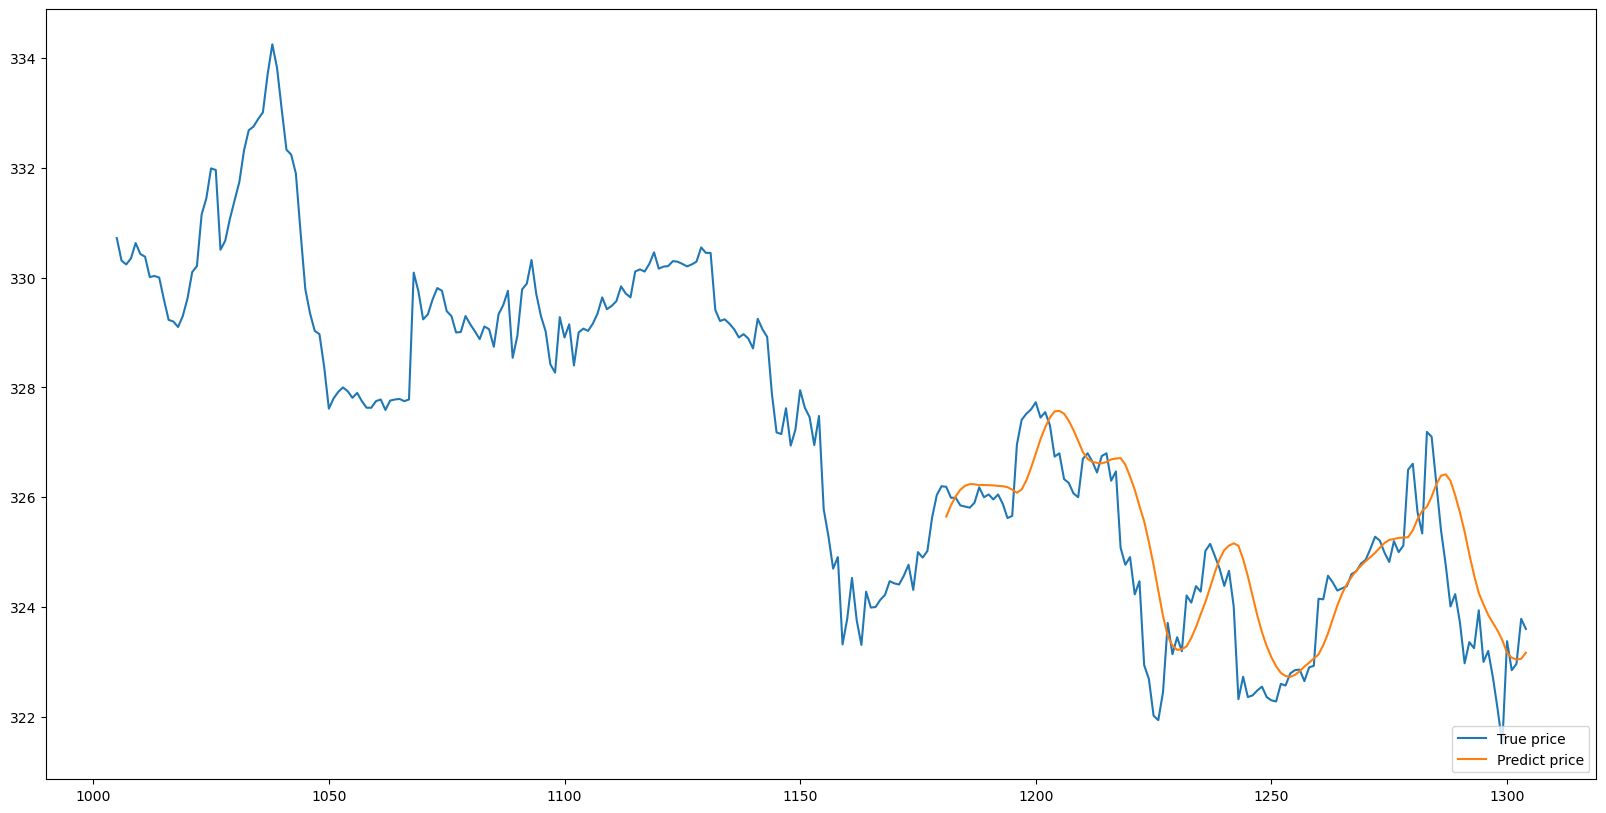

In [37]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

In [38]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI.h5")

Epoch 1/20
32/32 [==============================] - 6s 78ms/step - loss: 0.0472 - val_loss: 0.0123
Epoch 2/20
32/32 [==============================] - 1s 41ms/step - loss: 0.0032 - val_loss: 5.3157e-04
Epoch 3/20
32/32 [==============================] - 1s 43ms/step - loss: 0.0021 - val_loss: 5.6970e-04
Epoch 4/20
32/32 [==============================] - 1s 40ms/step - loss: 0.0019 - val_loss: 4.8215e-04
Epoch 5/20
32/32 [==============================] - 1s 44ms/step - loss: 0.0018 - val_loss: 3.9818e-04
Epoch 6/20
32/32 [==============================] - 1s 41ms/step - loss: 0.0017 - val_loss: 3.7995e-04
Epoch 7/20
32/32 [==============================] - 1s 41ms/step - loss: 0.0018 - val_loss: 6.4259e-04
Epoch 8/20
32/32 [==============================] - 1s 44ms/step - loss: 0.0016 - val_loss: 5.6921e-04
Epoch 9/20
32/32 [==============================] - 1s 42ms/step - loss: 0.0018 - val_loss: 3.4759e-04
Epoch 10/20
32/32 [==============================] - 1s 42ms/step - loss: 0.0

/Users/minhduc/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
model_lstm = load_model('./MODEL/LSTM_RSI.h5')


4/4 [==============================] - 1s 19ms/step


/var/folders/45/_wfmynmn3sn53x5yqxzhbl8m0000gp/T/ipykernel_5245/3901828709.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


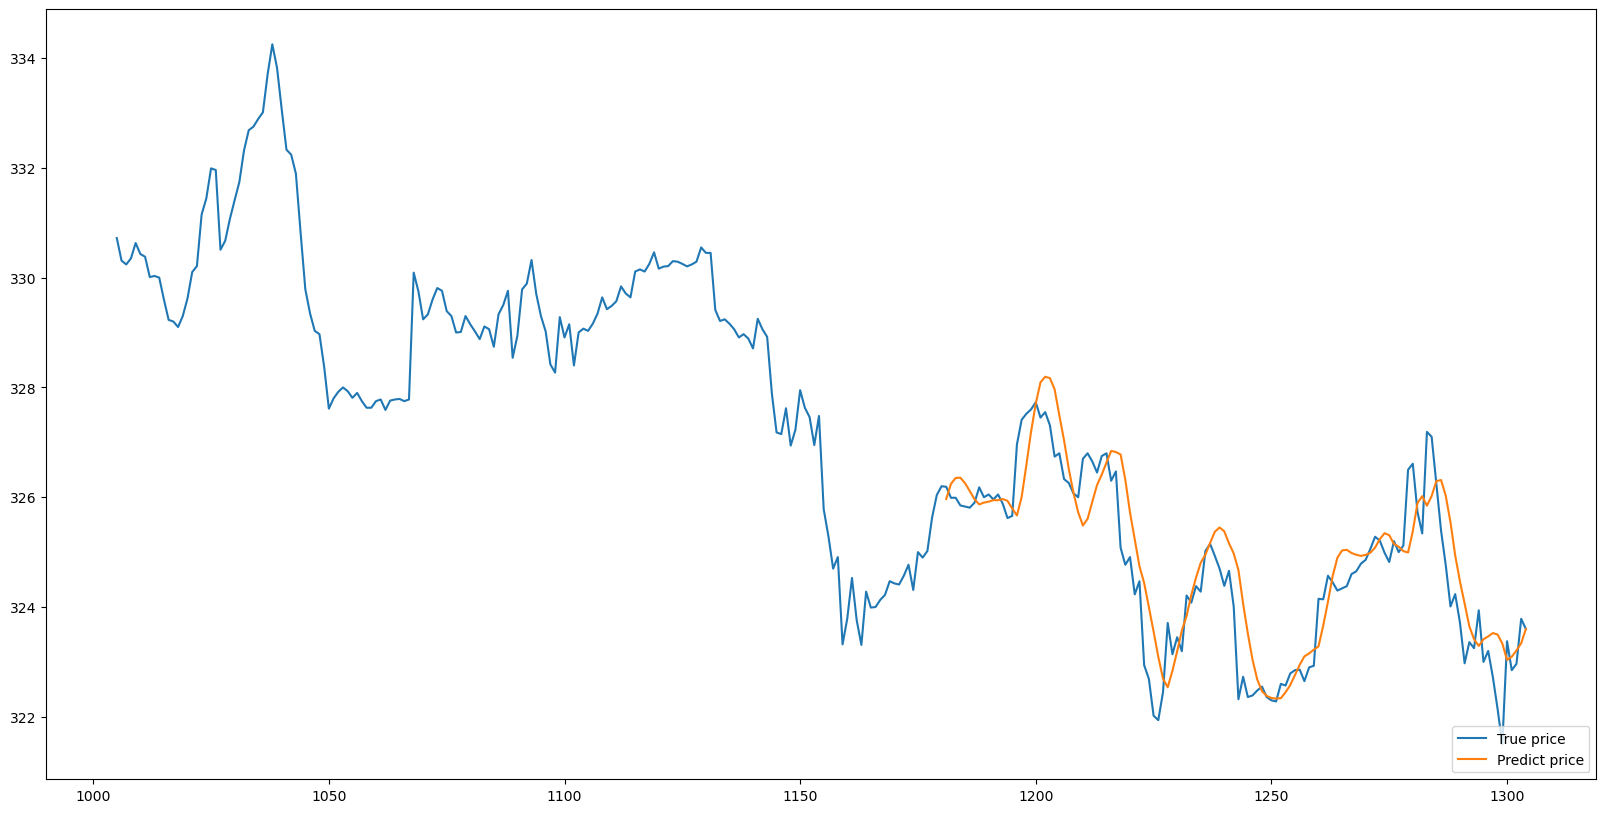

In [40]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

In [41]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS.h5")

Epoch 1/20
32/32 [==============================] - 6s 65ms/step - loss: 0.0458 - val_loss: 0.0119
Epoch 2/20
32/32 [==============================] - 1s 41ms/step - loss: 0.0052 - val_loss: 0.0017
Epoch 3/20
32/32 [==============================] - 1s 44ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 4/20
32/32 [==============================] - 1s 42ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 5/20
32/32 [==============================] - 1s 42ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 6/20
32/32 [==============================] - 1s 44ms/step - loss: 0.0025 - val_loss: 6.7823e-04
Epoch 7/20
32/32 [==============================] - 1s 42ms/step - loss: 0.0022 - val_loss: 6.8059e-04
Epoch 8/20
32/32 [==============================] - 1s 43ms/step - loss: 0.0020 - val_loss: 5.2880e-04
Epoch 9/20
32/32 [==============================] - 1s 41ms/step - loss: 0.0019 - val_loss: 6.9081e-04
Epoch 10/20
32/32 [==============================] - 1s 41ms/step - loss: 0.0016 - val_loss: 

/Users/minhduc/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
model_lstm = load_model('./MODEL/LSTM_BBANDS.h5')


4/4 [==============================] - 1s 18ms/step


/var/folders/45/_wfmynmn3sn53x5yqxzhbl8m0000gp/T/ipykernel_5245/3901828709.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


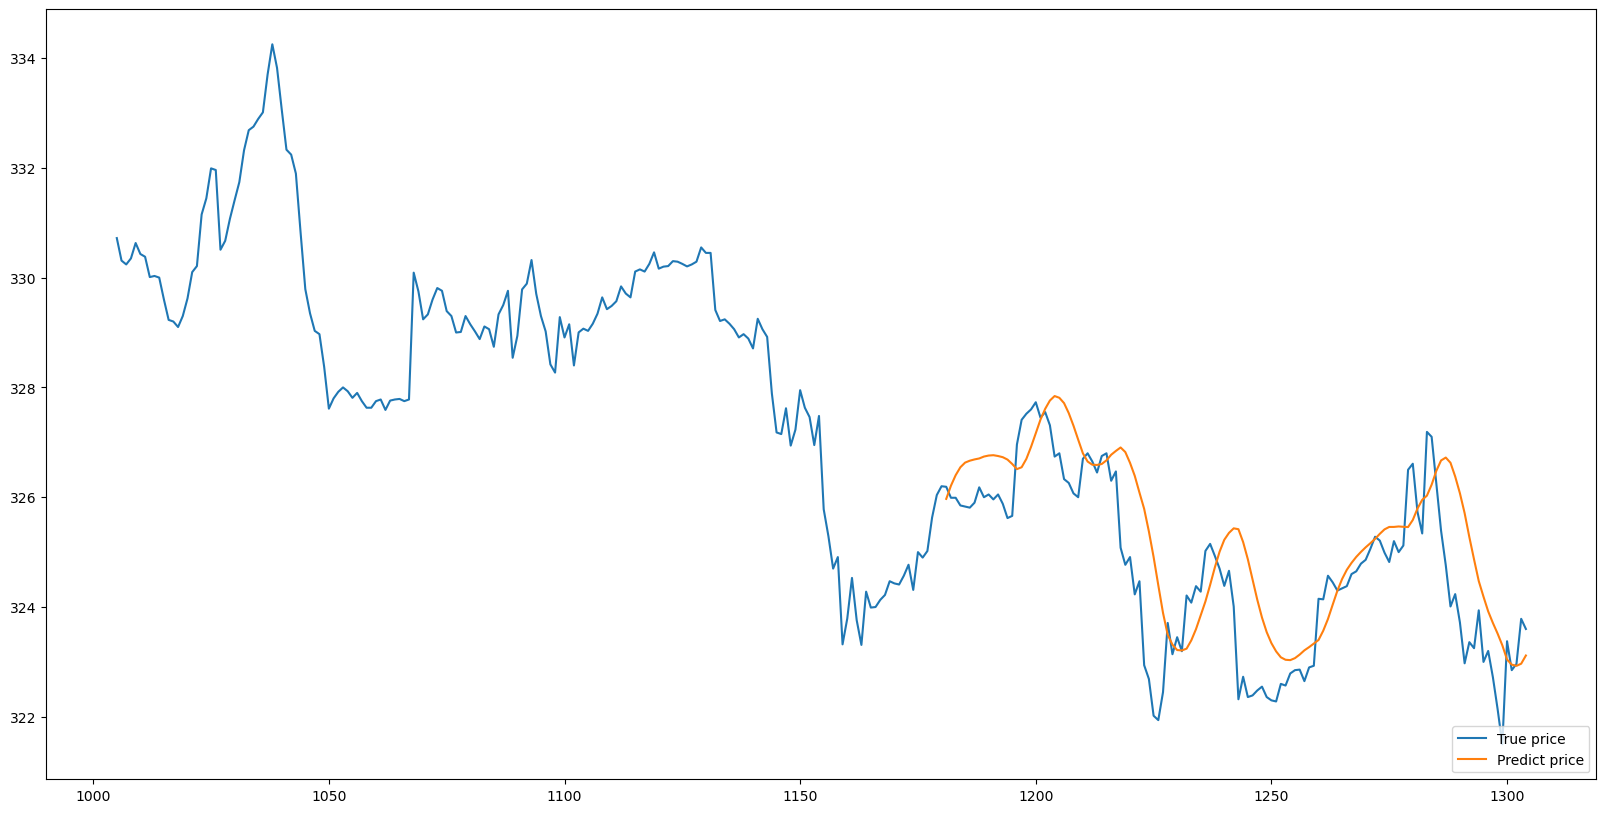

In [43]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()